In [1]:
!pip install tensorflow

In [2]:
!pip install --upgrade git+https://github.com/keras-team/keras-cv -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 4.0 MB/s eta 0:00:00


In [3]:
import os
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET

import tensorflow as tf
from tensorflow import keras

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization

Using TensorFlow backend


In [4]:
! curl -L "https://public.roboflow.com/ds/zEDe9ImuHb?key=BWnWVluozH" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

Streaming output truncated to the last 5000 lines.
 extracting: export/1478900823418519953_jpg.rf.9d336f889338cc36db87a7c3f0840829.jpg  
 extracting: export/1478900823418519953_jpg.rf.9d336f889338cc36db87a7c3f0840829.xml  
 extracting: export/1478900823418519953_jpg.rf.ti85719FAU1jvCtGL4xW.jpg  
 extracting: export/1478900823418519953_jpg.rf.ti85719FAU1jvCtGL4xW.xml  
 extracting: export/1478900823991222188_jpg.rf.1fcc2874b8932fc4ddebbb2e068d2247.jpg  
 extracting: export/1478900823991222188_jpg.rf.1fcc2874b8932fc4ddebbb2e068d2247.xml  
 extracting: export/1478900823991222188_jpg.rf.PV29ogGJgOiSFnL5IKtc.jpg  
 extracting: export/1478900823991222188_jpg.rf.PV29ogGJgOiSFnL5IKtc.xml  
 extracting: export/1478900824561352840_jpg.rf.18117b56585d4851cc9dcc2c3ee02e5e.jpg  
 extracting: export/1478900824561352840_jpg.rf.18117b56585d4851cc9dcc2c3ee02e5e.xml  
 extracting: export/1478900824561352840_jpg.rf.ioTTU6CiCUekgxoVvDhF.jpg  
 extracting: export/1478900824561352840_jpg.rf.ioTTU6CiCUekgxoV

In [5]:
os.getcwd()

'/content'

In [6]:
os.chdir('/content/export/')

In [7]:
os.getcwd()

'/content/export'

In [8]:
os.mkdir('annotations')

In [9]:
os.mkdir('images')

In [10]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCH = 5
GLOBAL_CLIPNORM = 10.0

In [11]:
import shutil
files = os.listdir()

for file in files:
    # If the file is a .jpg file
    if file.endswith('.jpg'):
        # Copy it into the 'images' directory
        shutil.copy(file, 'images')

In [12]:
import glob
# Get a list of all .jpg files in the current directory
files = glob.glob('*.jpg')

# For each file in the list
for file in files:
    # Delete the file
    os.remove(file)

In [13]:
files = os.listdir()

for file in files:
    # If the file is a .jpg file
    if file.endswith('.xml'):
        # Copy it into the 'images' directory
        shutil.copy(file, 'annotations')

In [14]:
# Get a list of all .jpg files in the current directory
files = glob.glob('*.xml')

# For each file in the list
for file in files:
    # Delete the file
    os.remove(file)

In [15]:
class_ids = [
    'car', 'pedestrian', 'biker', 'truck', 'trafficLight-Red',
        'trafficLight', 'trafficLight-Green', 'trafficLight-RedLeft',
        'trafficLight-GreenLeft', 'trafficLight-Yellow',
        'trafficLight-YellowLeft'
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))
print(class_mapping)


{0: 'car', 1: 'pedestrian', 2: 'biker', 3: 'truck', 4: 'trafficLight-Red', 5: 'trafficLight', 6: 'trafficLight-Green', 7: 'trafficLight-RedLeft', 8: 'trafficLight-GreenLeft', 9: 'trafficLight-Yellow', 10: 'trafficLight-YellowLeft'}


In [18]:
# Path to images and annotations
path_images = "/content/export/images/"
path_annot = "/content/export/annotations/"

# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".xml")
    ]
)
print(xml_files[0:2])
print('\n')
# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".jpg")
    ]
)
print(jpg_files[0:2])

['/content/export/annotations/1478019952686311006_jpg.rf.69b66a4136dffdf28f07a91f5649bb98.xml', '/content/export/annotations/1478019952686311006_jpg.rf.8AtteKyLJUNzZ2fEpxRj.xml']


['/content/export/images/1478019952686311006_jpg.rf.69b66a4136dffdf28f07a91f5649bb98.jpg', '/content/export/images/1478019952686311006_jpg.rf.8AtteKyLJUNzZ2fEpxRj.jpg']


In [32]:
import xml.etree.ElementTree as ET
tree = ET.parse('/content/export/annotations/1478019952686311006_jpg.rf.69b66a4136dffdf28f07a91f5649bb98.xml')

root=tree.getroot()
image_name = root.find("filename").text

classes = []

for obj in root.iter("object"):
    cls = obj.find("name").text
    classes.append(cls)

In [30]:
classes

['truck', 'car', 'car', 'pedestrian']

In [19]:
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(path_images, image_name)

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids




In [34]:
image_paths = []
bbox = []
classes = []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)

  0%|          | 0/30000 [00:00<?, ?it/s]

In [35]:
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

In [41]:
bbox

<tf.RaggedTensor [[[818.0, 570.0, 849.0, 604.0],
  [858.0, 578.0, 905.0, 610.0],
  [951.0, 575.0, 1005.0, 621.0],
  [1749.0, 483.0, 1819.0, 745.0]], [[818.0, 570.0, 849.0, 604.0],
                                    [858.0, 578.0, 905.0, 610.0],
                                    [951.0, 575.0, 1005.0, 621.0],
                                    [1749.0, 483.0, 1819.0, 745.0]],
 [[742.0, 578.0, 776.0, 614.0],
  [773.0, 589.0, 816.0, 620.0],
  [1453.0, 512.0, 1668.0, 614.0],
  [873.0, 587.0, 927.0, 633.0]]  , ..., [[2.0, 627.0, 264.0, 777.0],
                                         [235.0, 595.0, 389.0, 729.0],
                                         [365.0, 605.0, 431.0, 679.0],
                                         [1049.0, 553.0, 1349.0, 749.0]],
 [[1.0, 607.0, 143.0, 781.0],
  [147.0, 605.0, 247.0, 693.0],
  [711.0, 583.0, 801.0, 619.0],
  [897.0, 547.0, 1229.0, 791.0]], [[1.0, 607.0, 143.0, 781.0],
                                   [147.0, 605.0, 247.0, 693.0],
             

In [42]:
classes

<tf.RaggedTensor [[3, 0, 0, 1], [3, 0, 0, 1], [3, 0, 3, 0], ..., [0, 0, 0, 0], [0, 0, 0, 0],
 [0, 0, 0, 0]]>

In [43]:
image_paths

<tf.Tensor: shape=(30000,), dtype=string, numpy=
array([b'/content/export/images/1478019952686311006_jpg.rf.69b66a4136dffdf28f07a91f5649bb98.jpg',
       b'/content/export/images/1478019952686311006_jpg.rf.8AtteKyLJUNzZ2fEpxRj.jpg',
       b'/content/export/images/1478019953180167674_jpg.rf.1f70b6e7d6dd087262c91a2bfa668400.jpg',
       ...,
       b'/content/export/images/1478901536388465963_jpg.rf.a5ccdb41a1e656df146fd0fb6eaace4e.jpg',
       b'/content/export/images/1478901536960505700_jpg.rf.a4bf46ee5c6dcd2e33af72eba09d7d08.jpg',
       b'/content/export/images/1478901536960505700_jpg.rf.igQMHWITqUyG584WahoX.jpg'],
      dtype=object)>

In [46]:
for i in data:
    print(i)

Streaming output truncated to the last 5000 lines.
 [1755.0, 227.0, 1849.0, 397.0]]>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/export/images/1478901362717565375_jpg.rf.kl5wNUHsbgjAV1Seo0QU.jpg'>, <tf.Tensor: shape=(19,), dtype=int32, numpy=
array([3, 0, 0, 0, 0, 5, 5, 5, 0, 0, 5, 5, 0, 0, 0, 5, 0, 0, 5],
      dtype=int32)>, <tf.RaggedTensor [[3.0, 579.0, 177.0, 703.0],
 [203.0, 631.0, 297.0, 687.0],
 [209.0, 597.0, 297.0, 689.0],
 [263.0, 599.0, 429.0, 767.0],
 [365.0, 495.0, 865.0, 905.0],
 [589.0, 379.0, 629.0, 441.0],
 [771.0, 359.0, 819.0, 427.0],
 [783.0, 375.0, 815.0, 441.0],
 [805.0, 559.0, 1053.0, 681.0],
 [917.0, 597.0, 935.0, 633.0],
 [921.0, 355.0, 971.0, 441.0],
 [931.0, 369.0, 963.0, 425.0],
 [1157.0, 589.0, 1291.0, 735.0],
 [1161.0, 583.0, 1249.0, 723.0],
 [1173.0, 535.0, 1889.0, 953.0],
 [1287.0, 487.0, 1325.0, 555.0],
 [1727.0, 579.0, 1887.0, 669.0],
 [1733.0, 589.0, 1887.0, 661.0],
 [1755.0, 227.0, 1849.0, 397.0]]>)
(<tf.Tensor: shape=(), dtype=string, nu

In [47]:
# Determine the number of validation samples
num_val = int(len(xml_files) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

In [48]:
num_val

6000

In [49]:
val_data

<_TakeDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), RaggedTensorSpec(TensorShape([None]), tf.int32, 0, tf.int64), RaggedTensorSpec(TensorShape([None, None]), tf.float32, 1, tf.int64))>

In [50]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

In [51]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
    ]
)

In [52]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)


In [55]:
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

In the above code we have used some new methods that are available in Tensorflow.



1.   tf.ragged.constant: Ragged tensors are TensorFlow's way of representing lists of lists with varying lengths. They are used here because the number of bounding boxes and classes can vary for each image.

2.   tf.data.Dataset: A tf.data.Dataset represents a sequence of elements, where each element consists of one or more components. In this case, each element of the dataset is a tuple containing an image path, classes, and bounding boxes. The tf.data.Dataset.from_tensor_slices function is used to create the dataset. This function takes as input one (or multiple) tensors and returns a dataset. Each element in the returned dataset is a slice from the first dimension of the input tensor(s)

3. The tf.data.Dataset.map() method is used to apply a function to each element of a dataset. The syntax is:
    
    
    dataset.map(function, num_parallel_calls=None)

    a. function here is the object to which we want to apply transformation.
    b. num_parallel_calls is an optional argument which tells tensorflow to execute
    commands parallely. There is a default option called ** tf.data.Autotune ** . This
    automatically allocates CPU threads based on infrastructure.



In [56]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

In the above preparation of the data, we see that for training data, we are augmenting the data while we are resizing the data. There is a specific reason for this.

The primary reason for not using data augmentation in the validation set is to keep the validation data as close as possible to the real-world data on which the model will be eventually tested. Data augmentation is a technique used to artificially increase the size of the training dataset by creating modified versions of the images in the dataset. This can include operations such as rotations, translations, zooming, flipping, etc.

While data augmentation is beneficial for improving the model's ability to generalize from the training data, it is not typically used on validation or test data. This is because augmentation can distort the data, and you want your validation set to reflect the real-world data your model will be encountering as closely as possible learnopencv.com, towardsdatascience.com.

In your specific code snippet, you're using keras_cv.layers.JitteredResize to resize the images in the validation set. Resizing is a necessary pre-processing step because the model expects input images of a specific size. The JitteredResize function not only resizes the images but also adds a bit of random scaling (between 0.75 and 1.3 in your case) to introduce some amount of randomness in the validation data, which can help to make the validation process more robust. However, this is not considered data augmentation because it does not create additional data and is a necessary step for the model to process the images learnopencv.com, docs.ultralytics.com.

In summary, the primary goal of data augmentation is to increase the diversity of the training data and reduce overfitting. In contrast, the goal of the validation process is to estimate how well the model has learned to generalize from the training data to unseen data. Therefore, it's common practice to apply data augmentation to the training data and not to the validation data.

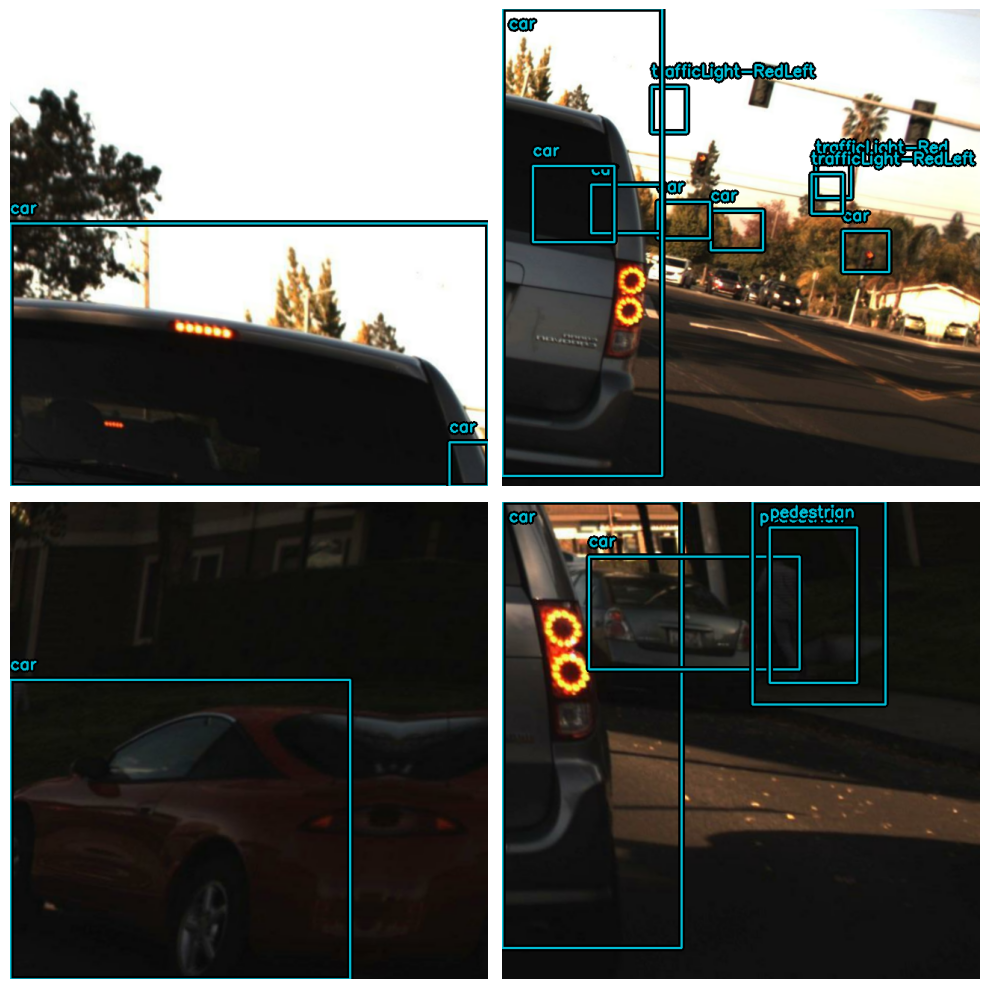

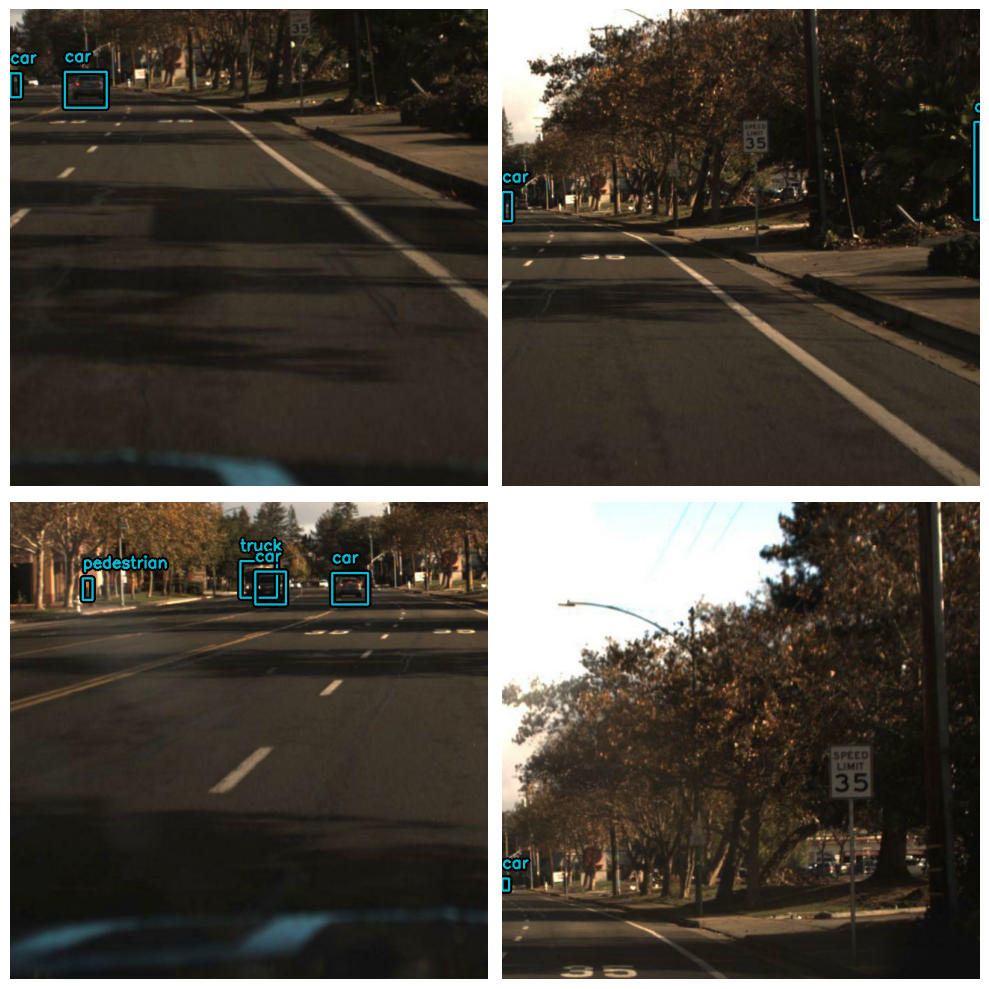

In [57]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

visualize_dataset(
    val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

In [58]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [59]:
for i in train_ds:
    print(i)

(<tf.Tensor: shape=(4, 640, 640, 3), dtype=float32, numpy=
array([[[[ 18.483765 ,  17.308872 ,  12.8173485],
         [ 19.860153 ,  17.543606 ,  12.885333 ],
         [ 20.907587 ,  17.907587 ,  12.907588 ],
         ...,
         [ 13.       ,  13.       ,  13.       ],
         [ 13.       ,  13.       ,  13.       ],
         [ 13.       ,  13.       ,  13.       ]],

        [[ 17.182135 ,  16.033194 ,  11.860821 ],
         [ 19.985262 ,  17.703644 ,  13.062834 ],
         [ 22.840414 ,  19.840414 ,  14.840414 ],
         ...,
         [ 13.       ,  13.       ,  13.       ],
         [ 13.       ,  13.       ,  13.       ],
         [ 13.       ,  13.       ,  13.       ]],

        [[ 17.926424 ,  16.80343  ,  12.741936 ],
         [ 20.806812 ,  18.560114 ,  13.936766 ],
         [ 24.122734 ,  21.122734 ,  16.122734 ],
         ...,
         [ 13.       ,  13.       ,  13.       ],
         [ 13.       ,  13.       ,  13.       ],
         [ 13.       ,  13.       ,  13.     

KeyboardInterrupt: ignored

In [60]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco"  # We will use yolov8 small backbone with coco weights
)

20596968/20596968 [==============================] - 0s 0us/step


In [61]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=1,
)

In [62]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)


In [63]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs




In [ ]:
"""
## Train the Model
"""

yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    callbacks=[EvaluateCOCOMetricsCallback(val_ds, "model.h5")],
)

In [64]:
! pip freeze > requirements.txt